# Growth Binary Data Evaluation

This notebook serves as data evaluation notebook (with a few interpretations). Here we combine datasets, do statistics and created figures.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
from PARAMS import *
from scipy.stats import ttest_ind
from statannotations.Annotator import Annotator
%run -i PARAMS.py

## 1. Batch additive screening

We know that centrifugating the samples is important so we will look at the centrifugated data and create barplots which compare the different additives but each with all four strains. Batch additives are additives which are composed of more than one metabolite. For all tests cobalt was already added to CGXII. All samples were inoculated at starting ODs around 0.2 and had 0.2% of Tween.

### 1. Data preparation

First we have to read all data into one dataframe. Then we will transform the dataframe to be able to plot it easily with sns.

In [3]:
datasets = [
    'growth_binary_results/CGXII_230111.csv', # 14
    'growth_binary_results/CGXII_230112.csv', # 16
    'growth_binary_results/CGXII_230117.csv', # 17
    #'growth_binary_results/CGXII_230124.csv', # 15
]
# read csv files
frames = [pd.read_csv(df).set_index('short').drop(['not c', '+Trace not c', '+Sacc not c']).reset_index() for df in datasets] 
# special case for strain 15 because of extra CasA measurement
frames = frames + [pd.read_csv('growth_binary_results/CGXII_230124.csv').set_index('short').drop(['not c', '+Trace not c', '+Sacc not c', '+CasA not c']).reset_index()]
# add all frames to one frame
data = pd.concat(frames, axis=1)
# remove duplicate 'short' columns
data = data.loc[:,~data.columns.duplicated()].copy()
data

,short,14-0-1,14-24-1,14-0-2,14-24-2,14-0-3,14-24-3,16-0-1,16-0-2,16-0-3,...,17-0-3,17-24-1,17-24-2,17-24-3,15-0-1,15-0-2,15-0-3,15-24-1,15-24-2,15-24-3
0,c,0.229,0.724,0.226,0.741,0.227,0.748,0.216,0.222,0.224,...,0.163,0.205,0.794,0.552,0.175,0.188,0.172,0.285,0.315,0.293
1,+Trace c,0.224,0.926,0.207,0.674,0.201,0.642,0.224,0.227,0.226,...,0.179,0.231,0.660,0.674,0.170,0.191,0.174,0.285,0.321,0.299
2,+Sacc c,0.221,0.736,0.183,0.644,0.211,0.712,0.203,0.223,0.226,...,0.180,0.279,1.222,0.691,0.164,0.172,0.168,0.269,0.288,0.298
3,+CasA c,0.234,1.723,0.226,1.738,0.199,1.628,0.205,0.229,0.233,...,0.181,0.778,5.730,7.690,0.180,0.189,0.182,0.941,0.977,0.990


In [4]:
# use stack() to bring short and measurment into rows
new = pd.DataFrame(data.set_index('short').sort_index().T.stack()).reset_index().rename({0:'OD'}, axis=1)
# split strain description
new[['strain', 'time', 'sample']] = new.level_0.str.split('-', expand=True)
# create two dataframes (at t=0 and at t=24)
time = [v for k, v in new.groupby('time')]
change = time[1]
# determine fold change by dividing t=24 by t=0
change['OD fold change'] = time[1]['OD'].values / time[0]['OD'].values
# change strain from lab names to real names
change['strain'].replace(STRAINS_LAB, inplace=True)
change

,level_0,short,OD,strain,time,sample,OD fold change
4,14-24-1,+CasA c,1.723,TS,24,1,7.363248
5,14-24-1,+Sacc c,0.736,TS,24,1,3.330317
6,14-24-1,+Trace c,0.926,TS,24,1,4.133929
7,14-24-1,c,0.724,TS,24,1,3.161572
12,14-24-2,+CasA c,1.738,TS,24,2,7.690265
13,14-24-2,+Sacc c,0.644,TS,24,2,3.519126
14,14-24-2,+Trace c,0.674,TS,24,2,3.256039
15,14-24-2,c,0.741,TS,24,2,3.278761
20,14-24-3,+CasA c,1.628,TS,24,3,8.180905
21,14-24-3,+Sacc c,0.712,TS,24,3,3.374408


### 2. Plotting and statistics

Now that we prepared the DataFrame, we can use `seaborn` and `statsannotator` to make nice barcharts with significance bars.

In [6]:
def create_barplot_stats(data, x, y, hue, hue_order, pair1=None, pair2=None):
    strains = STRAINS_LAB.values()
    
    ### barplot with errorbars ###
    ax = sns.barplot(data=data, x=x, y=y, hue=hue, 
                 estimator=np.mean, 
                 hue_order=hue_order,
                 palette=[greys[8], greys[0]], edgecolor='k',
                 capsize=.15, errwidth=1, errcolor='k',
                 order=STRAINS_LAB.values())
    
    ### statistics ###
    # use hue_order to infer pairs if not given
    if pair1 is None:
        pair1 = hue_order[0]
        pair2 = hue_order[1]
        
    pairs = []
    pairs = pairs + [((strain, pair1), (strain, pair2))
                for strain in strains]
    
    annotator = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue, hue_order=hue_order, order=STRAINS_LAB.values())
    annotator.configure(test='t-test_ind', text_format='star', loc='outside')
    annotator.apply_test().annotate()
    
    ### styling ###
    #ax.legend(title=None, ncol=2)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.05), ncol=3, title=None, frameon=False)
    ax.tick_params(bottom=False) 
    ax.axhline(2, linestyle='dashed', color='k')
    ax.set_xlabel(None)
    
    return ax

In [6]:
# inputs that wont change
data = change
x = 'strain'
y = 'OD fold change'
hue = 'short'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_c vs. 1197_+Trace c: t-test independent samples, P_val:4.267e-01 t=-8.840e-01
TS_c vs. TS_+Trace c: t-test independent samples, P_val:4.082e-01 t=-9.231e-01
1115_c vs. 1115_+Trace c: t-test independent samples, P_val:5.014e-03 t=-5.593e+00
1116_c vs. 1116_+Trace c: t-test independent samples, P_val:9.407e-01 t=7.912e-02


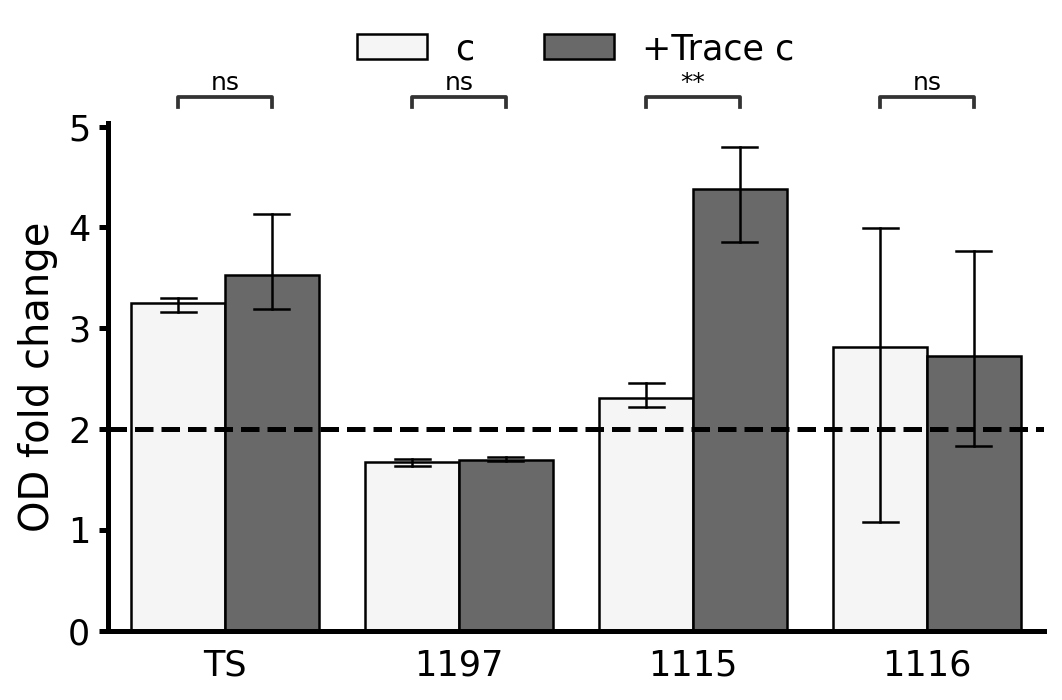

In [7]:
# input
hue_order = ['c', '+Trace c']
fig = create_barplot_stats(data,x,y,hue,hue_order)
plt.tight_layout()
plt.savefig('growth_binary_figures/plots_with_stats/trace.png')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_c vs. 1197_+Sacc c: t-test independent samples, P_val:5.864e-01 t=-5.908e-01
TS_c vs. TS_+Sacc c: t-test independent samples, P_val:8.319e-02 t=-2.297e+00
1115_c vs. 1115_+Sacc c: t-test independent samples, P_val:6.640e-01 t=4.682e-01
1116_c vs. 1116_+Sacc c: t-test independent samples, P_val:5.608e-01 t=-6.336e-01


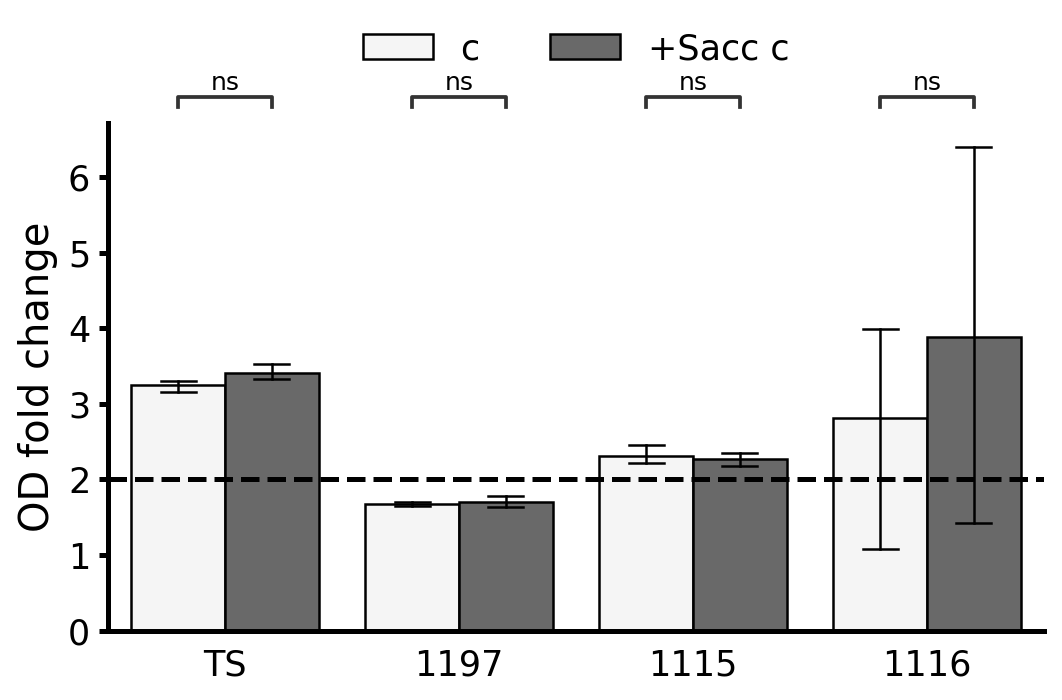

In [8]:
hue_order = ['c', '+Sacc c']
create_barplot_stats(data,x,y,hue,hue_order)
plt.tight_layout()
plt.savefig('growth_binary_figures/plots_with_stats/sacc.png')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_c vs. 1197_+CasA c: t-test independent samples, P_val:1.834e-06 t=-4.249e+01
TS_c vs. TS_+CasA c: t-test independent samples, P_val:4.869e-05 t=-1.865e+01
1115_c vs. 1115_+CasA c: t-test independent samples, P_val:9.669e-03 t=-4.649e+00
1116_c vs. 1116_+CasA c: t-test independent samples, P_val:1.244e-01 t=-1.940e+00


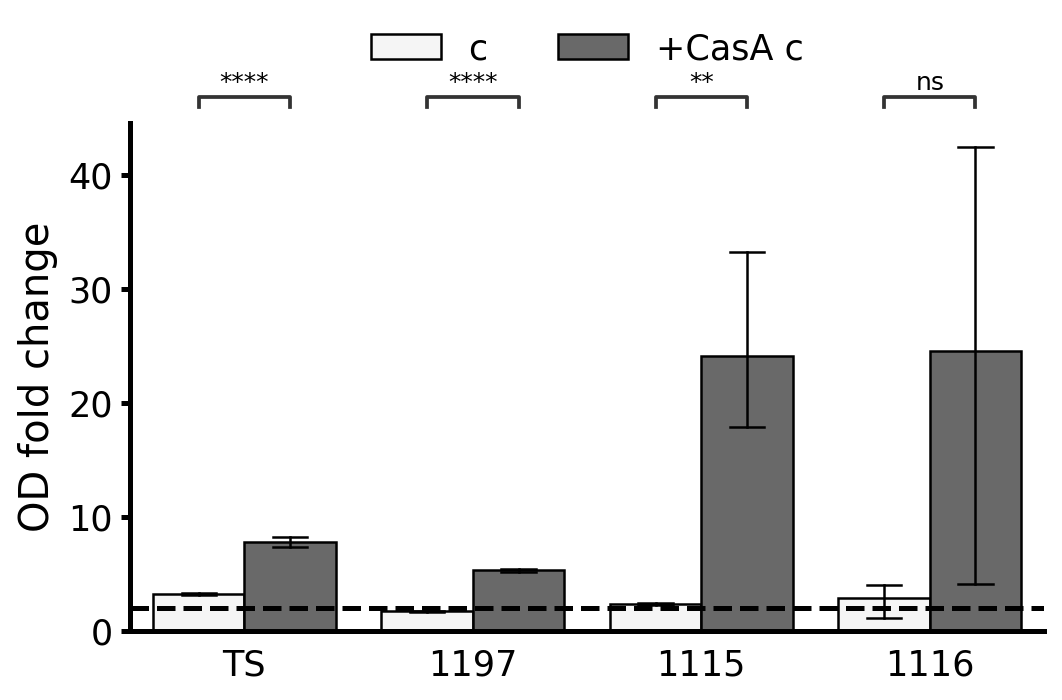

In [9]:
hue_order = ['c', '+CasA c']
create_barplot_stats(data,x,y,hue,hue_order)
plt.tight_layout()
plt.savefig('growth_binary_figures/plots_with_stats/casa.png')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1115_+Trace c vs. 1115_+CasA c: t-test independent samples, P_val:1.377e-02 t=-4.193e+00
1116_+Trace c vs. 1116_+CasA c: t-test independent samples, P_val:1.231e-01 t=-1.949e+00
TS_+Trace c vs. TS_+CasA c: t-test independent samples, P_val:3.965e-04 t=-1.094e+01
1197_+Trace c vs. 1197_+CasA c: t-test independent samples, P_val:1.728e-06 t=-4.313e+01


<AxesSubplot:ylabel='OD fold change'>

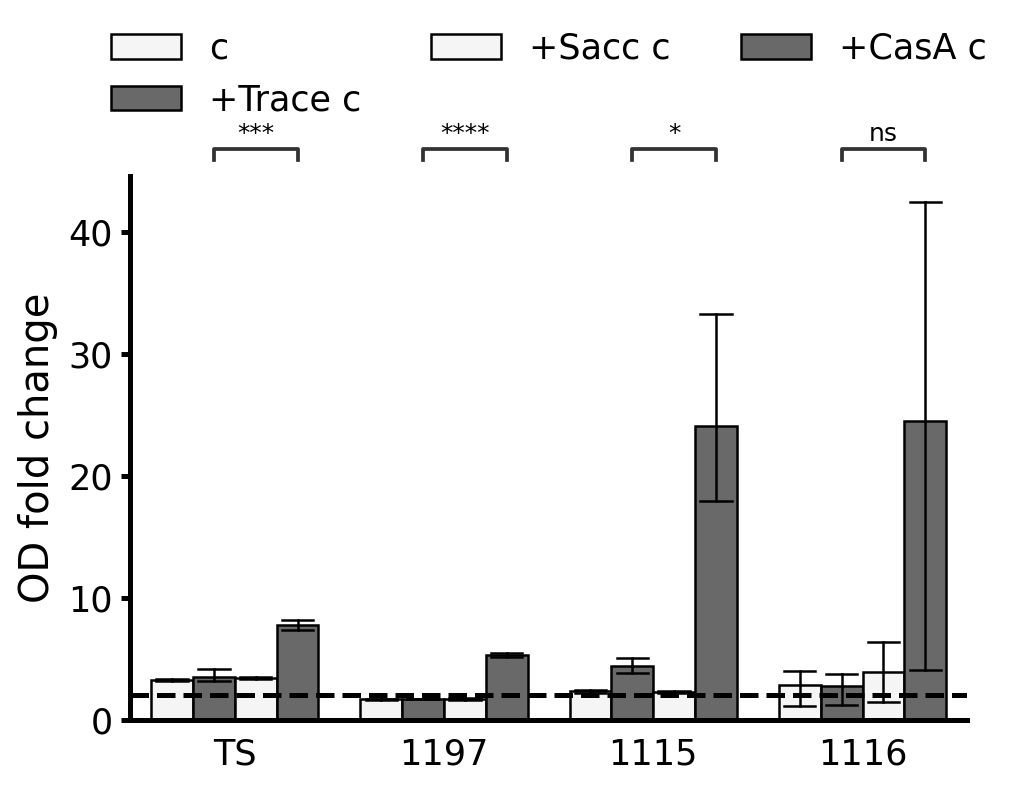

In [10]:
hue_order = ['c', '+Trace c', '+Sacc c', '+CasA c']
create_barplot_stats(data,x,y,hue,hue_order,'+Trace c', '+CasA c')

In [11]:
plt.close('all')

## 2. Specified additive screening

Here we will again use only data from centrifugated samples. We have different groups of additives which are strain specific but a generall overview on difference between deprived CGXII and full CGXII is desired. Full CGXII is without cobalt. Most of these tests were done without t=0 measurments. Inoculation to around 0.1 OD, without Tween.

### 1. Data preparation

#### Deprived vs. native CGXII

In [12]:
datasets = [
    'growth_binary_results/CGXII_221108.csv', # 14, 16
    'growth_binary_results/CGXII_221109.csv', # 15, 16
    'growth_binary_results/CGXII_221110.csv', # all
    #'growth_binary_results/CGXII_221116.csv', # all
    #'growth_binary_results/CGXII_221117.csv', # all
]
# read csv files
frames = []
for path in datasets:
    frame = pd.read_csv(path)
    try:
        frame = frame.set_index('short').drop(['-/+']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['-/++', '+/++']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['+/+']).reset_index()
    except:
        pass
    frames.append(frame)
# add all frames to one frame while keeping multiples of strain 14, 15 and 16
data = pd.concat(frames, axis=0)
data

,short,16-1,16-2,16-3,14-1,14-2,14-3,15-1,15-2,15-3,17-1,17-2,17-3
0,-/-,0.005,0.000,0.000,0.027,0.083,0.000,NaN,NaN,NaN,NaN,NaN,NaN
1,+/-,1.712,0.051,0.069,2.332,0.030,0.000,NaN,NaN,NaN,NaN,NaN,NaN
0,-/-,0.021,0.055,0.037,NaN,NaN,NaN,0.0300,0.040,0.024,NaN,NaN,NaN
1,+/-,1.290,1.517,1.850,NaN,NaN,NaN,2.1740,1.843,1.203,NaN,NaN,NaN
0,-/-,0.114,0.122,0.121,0.039,0.114,0.099,0.0250,0.046,0.055,0.086,0.098,0.045
1,+/-,0.162,0.170,0.176,0.164,0.097,0.187,0.0029,0.080,0.052,0.130,0.130,0.123


In [13]:
# use stack() to bring short and measurment into rows
new = pd.DataFrame(data.set_index('short').stack().reset_index().rename({0:'OD'}, axis=1))
# split into strain and replicate
new[['strain', 'sample']] = new.level_1.str.split('-', expand=True)
# split short column to be readable
#new['s1'], new['s2'] = new.short.str
#new.drop(['short', 's2'], axis=1, inplace=True)
#new.rename({'s1':'short'}, axis=1, inplace=True)
# change strain names to real names
new['strain'].replace(STRAINS_LAB, inplace=True)
# replace short by description
new['short'].replace({'-/-': 'deprived', '+/-': 'native'}, inplace=True)
depr = new
depr

,short,level_1,OD,strain,sample
0,deprived,16-1,0.0050,1115,1
1,deprived,16-2,0.0000,1115,2
2,deprived,16-3,0.0000,1115,3
3,deprived,14-1,0.0270,TS,1
4,deprived,14-2,0.0830,TS,2
5,deprived,14-3,0.0000,TS,3
6,native,16-1,1.7120,1115,1
7,native,16-2,0.0510,1115,2
8,native,16-3,0.0690,1115,3
9,native,14-1,2.3320,TS,1


#### Native vs predicted essential metabs

In [14]:
datasets = [
    'growth_binary_results/CGXII_221108.csv', # 14, 16
    'growth_binary_results/CGXII_221109.csv', # 15, 16
    'growth_binary_results/CGXII_221110.csv', # all
    'growth_binary_results/CGXII_221116.csv', # all
    'growth_binary_results/CGXII_221117.csv', # all
]
# read csv files
frames = []
for path in datasets:
    frame = pd.read_csv(path)
    try:
        frame = frame.set_index('short').drop(['-/+']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['-/-']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['-/++']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['+/++']).reset_index()
    except:
        pass
    frames.append(frame)
# add all frames to one frame while keeping multiples of strain 14, 15 and 16
data = pd.concat(frames, axis=0)
data

,short,16-1,16-2,16-3,14-1,14-2,14-3,15-1,15-2,15-3,17-1,17-2,17-3
0,+/-,1.712,0.051,0.069,2.332,0.030,0.000,NaN,NaN,NaN,NaN,NaN,NaN
1,+/+,0.404,0.067,0.000,0.000,0.001,0.000,NaN,NaN,NaN,NaN,NaN,NaN
0,+/-,1.290,1.517,1.850,NaN,NaN,NaN,2.1740,1.843,1.203,NaN,NaN,NaN
1,+/+,NaN,NaN,NaN,NaN,NaN,NaN,1.0750,0.993,0.175,NaN,NaN,NaN
0,+/-,0.162,0.170,0.176,0.164,0.097,0.187,0.0029,0.080,0.052,0.130,0.130,0.123
1,+/+,NaN,NaN,NaN,0.123,0.109,0.150,NaN,NaN,NaN,0.072,0.101,0.090
0,+/-,0.128,0.174,0.135,0.153,0.160,0.135,0.0570,0.076,0.071,0.080,0.081,0.083
1,+/+,NaN,NaN,NaN,0.128,0.195,0.156,NaN,NaN,NaN,0.125,0.069,0.048
0,+/-,0.063,0.089,0.067,0.179,0.214,0.120,0.0620,0.082,0.079,0.085,0.068,0.052
1,+/+,NaN,NaN,NaN,0.128,0.177,0.146,NaN,NaN,NaN,0.085,0.068,0.052


In [15]:
# use stack() to bring short and measurment into rows
new = pd.DataFrame(data.set_index('short').stack().reset_index().rename({0:'OD'}, axis=1))
# split into strain and replicate
new[['strain', 'sample']] = new.level_1.str.split('-', expand=True)
# split short column to be readable
#new['s1'], new['s2'] = new.short.str
#new.drop(['short', 's2'], axis=1, inplace=True)
#new.rename({'s1':'short'}, axis=1, inplace=True)
# change strain names to real names
new['strain'].replace(STRAINS_LAB, inplace=True)
# replace short by description
new['short'].replace({'+/+': 'essential', '+/-': 'native'}, inplace=True)
ess = new
ess

,short,level_1,OD,strain,sample
0,native,16-1,1.712,1115,1
1,native,16-2,0.051,1115,2
2,native,16-3,0.069,1115,3
3,native,14-1,2.332,TS,1
4,native,14-2,0.030,TS,2
...,...,...,...,...,...
70,essential,14-2,0.177,TS,2
71,essential,14-3,0.146,TS,3
72,essential,17-1,0.085,1116,1
73,essential,17-2,0.068,1116,2


#### Native vs. predicted essential metabs AND enhancing metabs

In [16]:
datasets = [
    'growth_binary_results/CGXII_221108.csv', # 14, 16
    'growth_binary_results/CGXII_221109.csv', # 15, 16
    'growth_binary_results/CGXII_221110.csv', # all
    'growth_binary_results/CGXII_221116.csv', # all
    'growth_binary_results/CGXII_221117.csv', # all
]
# read csv files
frames = []
for path in datasets:
    frame = pd.read_csv(path)
    try:
        frame = frame.set_index('short').drop(['-/+']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['-/-']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['-/+']).reset_index()
    except:
        pass
    try:
        frame = frame.set_index('short').drop(['+/+']).reset_index()
    except:
        pass
    frames.append(frame)
# add all frames to one frame while keeping multiples of strain 14, 15 and 16
data = pd.concat(frames, axis=0)
data

,short,16-1,16-2,16-3,14-1,14-2,14-3,15-1,15-2,15-3,17-1,17-2,17-3
0,+/-,1.712,0.051,0.069,2.332,0.030,0.000,NaN,NaN,NaN,NaN,NaN,NaN
0,-/++,0.083,0.074,0.085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,+/-,1.290,1.517,1.850,NaN,NaN,NaN,2.1740,1.843,1.203,NaN,NaN,NaN
2,+/++,1.436,0.588,0.876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,-/++,0.137,0.176,0.145,NaN,NaN,NaN,0.0540,0.060,0.046,NaN,NaN,NaN
1,+/-,0.162,0.170,0.176,0.164,0.097,0.187,0.0029,0.080,0.052,0.130,0.130,0.123
2,+/++,0.130,0.160,0.133,NaN,NaN,NaN,0.1570,0.122,0.107,NaN,NaN,NaN
0,+/-,0.128,0.174,0.135,0.153,0.160,0.135,0.0570,0.076,0.071,0.080,0.081,0.083
1,+/++,0.112,0.100,0.111,NaN,NaN,NaN,0.1990,0.149,0.198,NaN,NaN,NaN
0,+/-,0.063,0.089,0.067,0.179,0.214,0.120,0.0620,0.082,0.079,0.085,0.068,0.052


In [17]:
# use stack() to bring short and measurment into rows
new = pd.DataFrame(data.set_index('short').stack().reset_index().rename({0:'OD'}, axis=1))
# split into strain and replicate
new[['strain', 'sample']] = new.level_1.str.split('-', expand=True)
# split short column to be readable
#new['s1'], new['s2'] = new.short.str
#new.drop(['short', 's2'], axis=1, inplace=True)
#new.rename({'s1':'short'}, axis=1, inplace=True)
# change strain names to real names
new['strain'].replace(STRAINS_LAB, inplace=True)
# replace short by description
new['short'].replace({'+/++': 'enhanced', '+/-': 'native'}, inplace=True)
enh = new
enh

,short,level_1,OD,strain,sample
0,native,16-1,1.712,1115,1
1,native,16-2,0.051,1115,2
2,native,16-3,0.069,1115,3
3,native,14-1,2.332,TS,1
4,native,14-2,0.030,TS,2
...,...,...,...,...,...
73,enhanced,16-2,0.085,1115,2
74,enhanced,16-3,0.038,1115,3
75,enhanced,15-1,0.128,1197,1
76,enhanced,15-2,0.126,1197,2


### 2. Plotting and statistics

In [18]:
# inputs that wont change
x = 'strain'
y = 'OD'
hue = 'short'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_native vs. 1197_deprived: t-test independent samples, P_val:5.810e-02 t=2.139e+00
TS_native vs. TS_deprived: t-test independent samples, P_val:3.013e-01 t=1.090e+00
1115_native vs. 1115_deprived: t-test independent samples, P_val:1.420e-02 t=2.751e+00
1116_native vs. 1116_deprived: t-test independent samples, P_val:3.399e-02 t=3.166e+00


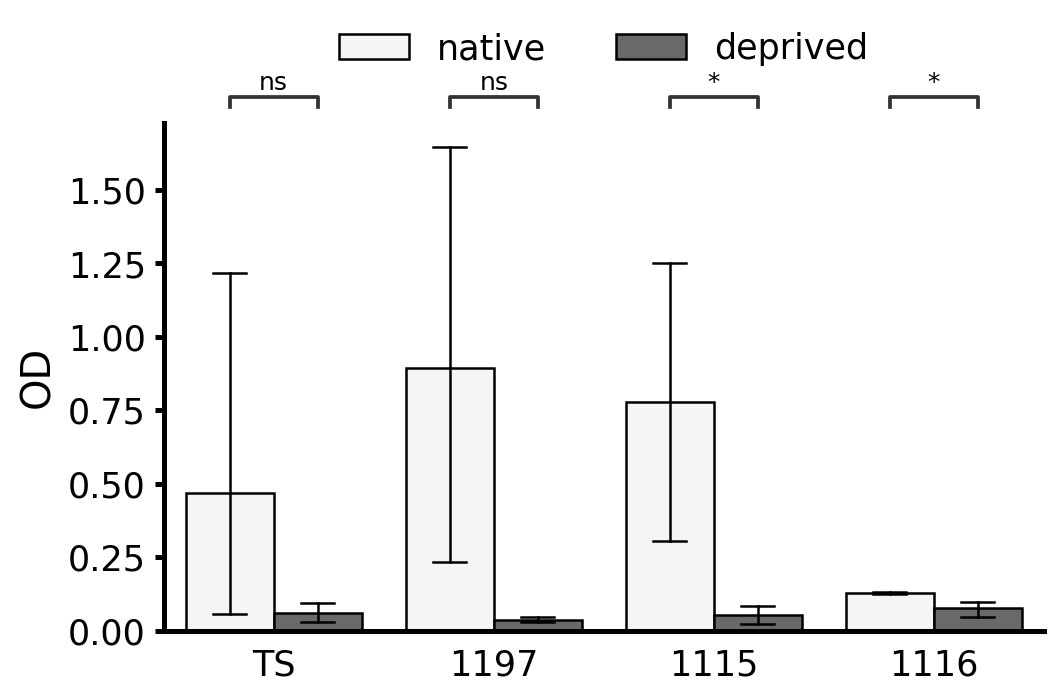

In [19]:
data = depr
hue_order = ['native', 'deprived']
create_barplot_stats(data,x,y,hue,hue_order)
plt.tight_layout()
plt.savefig('growth_binary_figures/plots_with_stats/deprived.png')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_native vs. 1197_essential: t-test independent samples, P_val:5.924e-01 t=-5.489e-01
TS_native vs. TS_essential: t-test independent samples, P_val:2.812e-01 t=1.105e+00
1115_native vs. 1115_essential: t-test independent samples, P_val:4.003e-01 t=8.641e-01
1116_native vs. 1116_essential: t-test independent samples, P_val:2.918e-01 t=1.090e+00


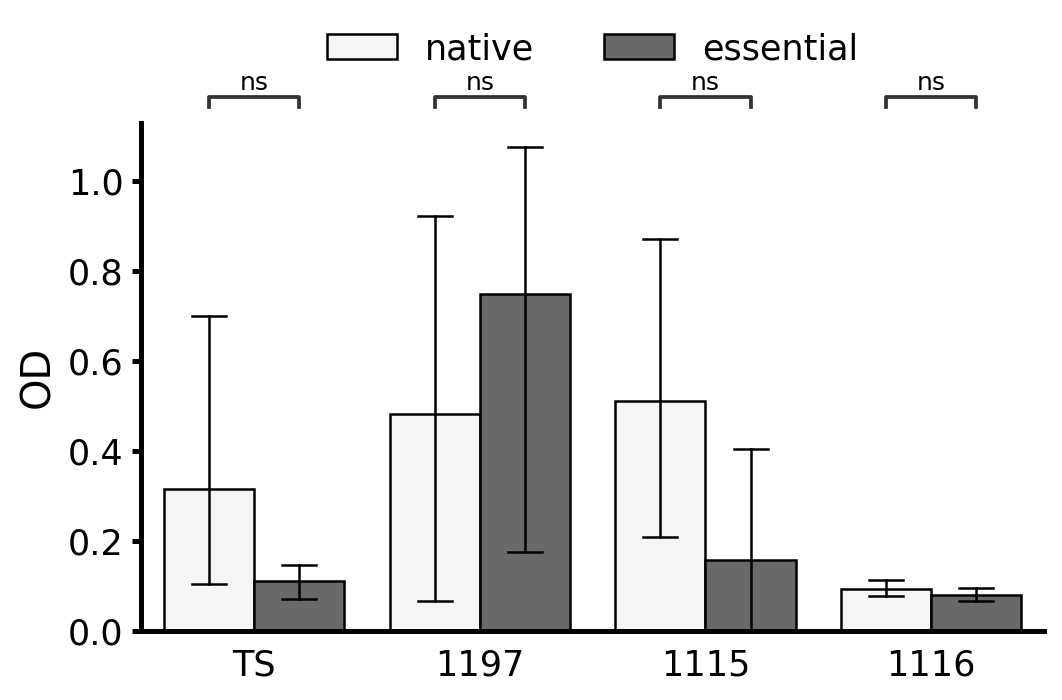

In [20]:
data = ess
hue_order = ['native', 'essential']
create_barplot_stats(data,x,y,hue,hue_order)
plt.tight_layout()
plt.savefig('growth_binary_figures/plots_with_stats/essential.png')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_native vs. 1197_enhanced: t-test independent samples, P_val:2.227e-01 t=1.261e+00
TS_native vs. TS_enhanced: t-test independent samples, P_val:nan t=nan
1115_native vs. 1115_enhanced: t-test independent samples, P_val:4.059e-01 t=8.454e-01
1116_native vs. 1116_enhanced: t-test independent samples, P_val:nan t=nan


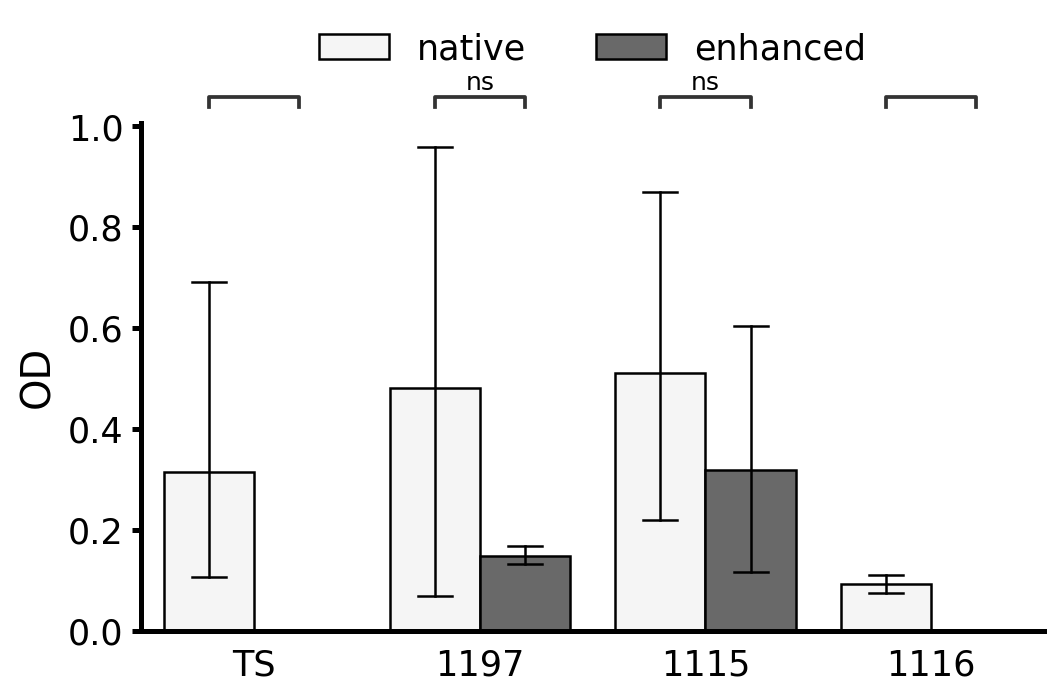

In [21]:
data = enh
hue_order = ['native', 'enhanced']
create_barplot_stats(data,x,y,hue,hue_order)
plt.tight_layout()
plt.savefig('growth_binary_figures/plots_with_stats/enhanced.png')

In [22]:
plt.close('all')

## 3. OD fold changes derived from growth curves

The same approach to 24h fold changes and statistical evaluation can be taken towards results from growth curves. We need to extract the values for t=0 and t=24 and then we can apply the same code as we did before.

### 1. Utilities for plate reader data

In [23]:
# Utilities

from datetime import datetime
path = '../plate_reader/plate_reader_results/'

def add_time(df):
    m = [isinstance(i, datetime) for i in df['Time']]
    df['timedelta'] = pd.to_timedelta(df['Time'].astype(str), errors='coerce')
    df.loc[m, 'timedelta'] = df.loc[m, 'Time'].apply(lambda t: pd.Timestamp(str(t)) - pd.Timestamp('1899-12-31'))
    df['Time'] = (df['timedelta'] - df['timedelta'][0])
    df['Time'] = df['Time'].dt.total_seconds() / 60
    df['Time'] += 15
    return df.drop('timedelta', axis=1)

def extract_columns(df, conditions, bio_rep=False, bio_rep_name=''):
    """transforms excel table to df where the technical triplicates are averaged

    Args:
        df (pandas-df): excel from plate reader loaded
        conditions (dict): plate_layout loaded with convert_layout()
    """

    triplicates = df.iloc[:,2:].groupby(np.arange(len(df.iloc[:,2:].columns))//3, axis=1).mean()

    blank = triplicates[triplicates.columns[3::4]]
    blank.columns = np.arange(8)

    left = triplicates[triplicates.columns[::4]]
    left.columns = np.arange(8)
    left = left - blank
    left = left.rename(columns=conditions)
    left = df.iloc[:,:1].join(left, how='outer')
    left = add_time(left)

    middle = triplicates[triplicates.columns[1::4]]
    middle.columns = np.arange(8)
    middle = middle - blank
    middle = middle.rename(columns=conditions)
    middle = df.iloc[:,:1].join(middle, how='outer')
    middle = add_time(middle)

    right = triplicates[triplicates.columns[2::4]]
    right.columns = np.arange(8)
    right = right - blank
    right = right.rename(columns=conditions)
    right = df.iloc[:,:1].join(right, how='outer')
    right = add_time(right)
    
    def double_std(array):
        return np.std(array) * 2
    
    if bio_rep:
        df_concat = pd.concat((left, middle, right))
        by_row_index = df_concat.groupby(df_concat.index)
        df_means = by_row_index.mean()
        df_errors = by_row_index.agg([np.mean, np.std])
        return_dict = {conditions['A']:left,
                   conditions['B']:middle,
                   conditions['C']:right,
                   bio_rep_name: df_means}
    
    else:
        return_dict = {conditions['A']:left,
                   conditions['B']:middle,
                   conditions['C']:right}
        df_errors = None
    
    return  return_dict, df_errors

def convert_layout(plate_layout_file = 'plate_layout.csv'):
    """converts csv layout file to work with other functions

    Args:
        plate_layout_file (str): Path to csv with layout. Defaults to 'plate_layout.csv'.

    Returns:
        dict: date as keys and layout as value (entry of the row)
    """
    layout = pd.read_csv(plate_layout_file)
    layout_dict = {}

    for entry in layout.to_dict('records'):
        new_dict = {}
        for k, v in entry.items():
            try: 
                k = int(k)
                new_dict[k] = v
            except(ValueError):
                new_dict[k] = v
        layout_dict[new_dict['date']] = new_dict
    
    return layout_dict

def get_info(excel_file):
    date = excel_file[:6]
    nice_date = date[4:] + '.' + date[2:4] + '.20' + date[:2]
    plate_layout = convert_layout('../plate_reader/plate_layout.csv')[int(date)]
    nrows = 0 
    if plate_layout['duration'] == 24.0:
        nrows = 96 #96 for 24
    if plate_layout['duration'] == 48.0:
        nrows = 193 #193 for 48h
    bio_rep_name = ''
    if plate_layout['biological replicates']:
        bio_rep_name = str(int(plate_layout['strain']))
    return nrows, plate_layout, bio_rep_name, nice_date

def get_growth_frame(excel_file, strain): # only works with bio rep
    nrows, plate_layout, bio_rep_name, nice_date = get_info(excel_file)
    df = pd.read_excel(path+excel_file, usecols="B:CU", skiprows=57, nrows=nrows)
    growth, errors = extract_columns(df, plate_layout, plate_layout['biological replicates'], bio_rep_name)
    return growth

### 2. Data preparation

In [24]:
#pd.options.mode.chained_assignment = None
excels = ['220610','220614', '220615', '220628']
excel_file = '220610_Cstr.xlsx' 
strains = ['15', '14', '16', '17']
strain = '15'

frames = []
i = 0
for excel in excels:
    excel_file = excel + '_Cstr.xlsx'
    strain = strains[i]
    for sample in ['-1', '-2', '-3']:
        growth = get_growth_frame(excel_file, strain)[strain+sample]
        dat = growth.loc[(growth['Time']== 15.0) | (growth['Time']== 1440.0)].abs()
        dat['sample'] = sample[1:]
        dat['strain'] = strain
        frames.append(dat)
    i = i + 1
data = pd.concat(frames, axis=0)
data

,Time,LB,M9,M9+CasA,SNM+CasA,SNM+Vit+Trace,RPMI,BHI,TSB,sample,strain
0,15.0,0.009000,0.004667,0.005333,0.009333,0.006333,0.005667,0.009667,0.010000,1,15
95,1440.0,0.228000,0.026000,0.068000,0.106333,0.046667,0.350667,0.143667,0.385000,1,15
0,15.0,0.010667,0.007667,0.009667,0.008000,0.018667,0.014333,0.007667,0.012667,2,15
95,1440.0,0.302000,0.025333,0.075667,0.095000,0.061000,0.369667,0.165667,0.554333,2,15
0,15.0,0.008000,0.007000,0.007667,0.007333,0.013000,0.005667,0.007667,0.007000,3,15
95,1440.0,0.421333,0.022000,0.048667,0.086667,0.049333,0.350333,0.206000,0.550333,3,15
0,15.0,0.008000,0.001667,0.000333,0.001000,0.003667,0.001667,0.005333,0.009000,1,14
95,1440.0,0.480667,0.002333,0.000333,0.090667,0.001000,0.281000,0.664000,0.532667,1,14
0,15.0,0.000667,0.001000,0.001667,0.000667,0.003667,0.000333,0.004333,0.004000,2,14
95,1440.0,0.582667,0.001333,0.002333,0.095000,0.017667,0.285333,0.272667,0.342333,2,14


In [25]:
# group by time to determine fold
time = [v for k, v in data.groupby('Time')]
change = time[1].set_index(['sample', 'strain']).divide(time[0].set_index(['sample', 'strain']))
change.reset_index(inplace=True)
# melt to make columns into id variables
change = change.melt(id_vars=['sample', 'strain', 'Time']).rename({'variable':'medium', 'value':'OD fold change'}, axis=1)
# replace strain names
change['strain'].replace(STRAINS_LAB, inplace=True)
change

,sample,strain,Time,medium,OD fold change
0,1,1197,96.0,LB,25.333333
1,2,1197,96.0,LB,28.312500
2,3,1197,96.0,LB,52.666667
3,1,TS,96.0,LB,60.083333
4,2,TS,96.0,LB,874.000000
...,...,...,...,...,...
91,2,1115,96.0,TSB,78.629630
92,3,1115,96.0,TSB,260.214286
93,1,1116,96.0,TSB,45.090909
94,2,1116,96.0,TSB,32.413793


### 3. Plotting and statistics

In [26]:
# inputs that wont change
data = change
x = 'strain'
y = 'OD fold change'
hue = 'medium'

/Users/baeuerle/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/baeuerle/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_M9 vs. 1197_M9+CasA: t-test independent samples, P_val:7.600e-02 t=-2.380e+00
TS_M9 vs. TS_M9+CasA: t-test independent samples, P_val:6.541e-01 t=-4.834e-01
1115_M9 vs. 1115_M9+CasA: t-test independent samples, P_val:nan t=nan
1116_M9 vs. 1116_M9+CasA: t-test independent samples, P_val:1.438e-01 t=-1.814e+00


<AxesSubplot:ylabel='OD fold change'>

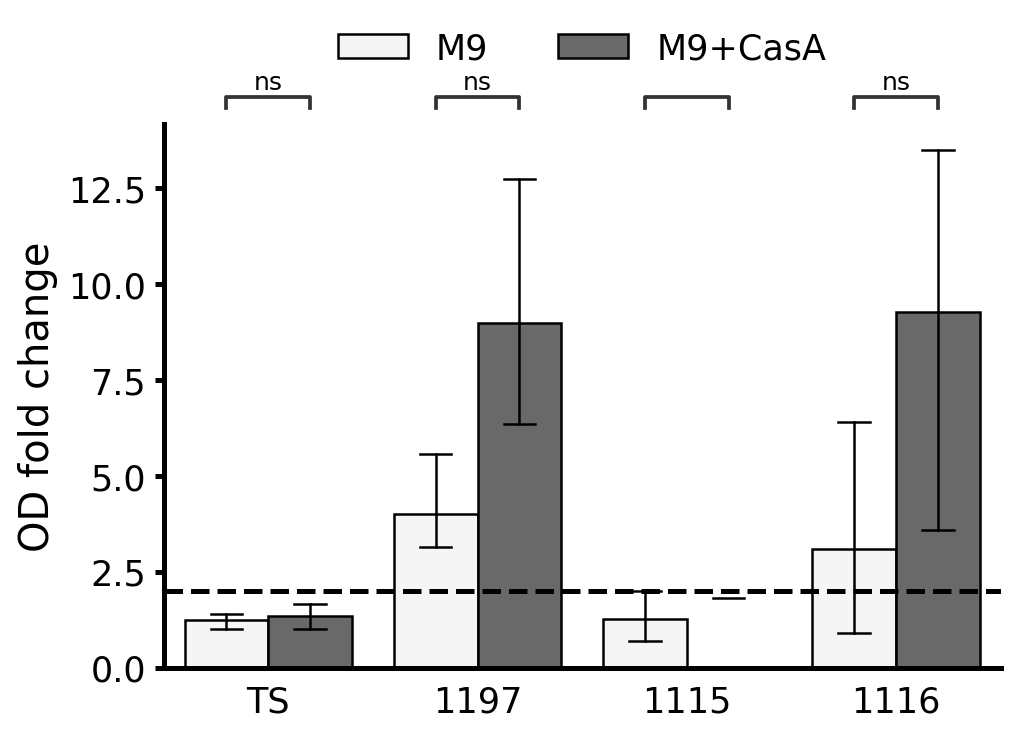

In [27]:
hue_order = ['M9', 'M9+CasA']
create_barplot_stats(data,x,y,hue,hue_order)

/Users/baeuerle/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/baeuerle/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_SNM+Vit+Trace vs. 1197_SNM+CasA: t-test independent samples, P_val:6.053e-03 t=-5.308e+00
TS_SNM+Vit+Trace vs. TS_SNM+CasA: t-test independent samples, P_val:5.714e-03 t=-5.394e+00
1115_SNM+Vit+Trace vs. 1115_SNM+CasA: t-test independent samples, P_val:nan t=nan
1116_SNM+Vit+Trace vs. 1116_SNM+CasA: t-test independent samples, P_val:1.241e-01 t=-1.942e+00


<AxesSubplot:ylabel='OD fold change'>

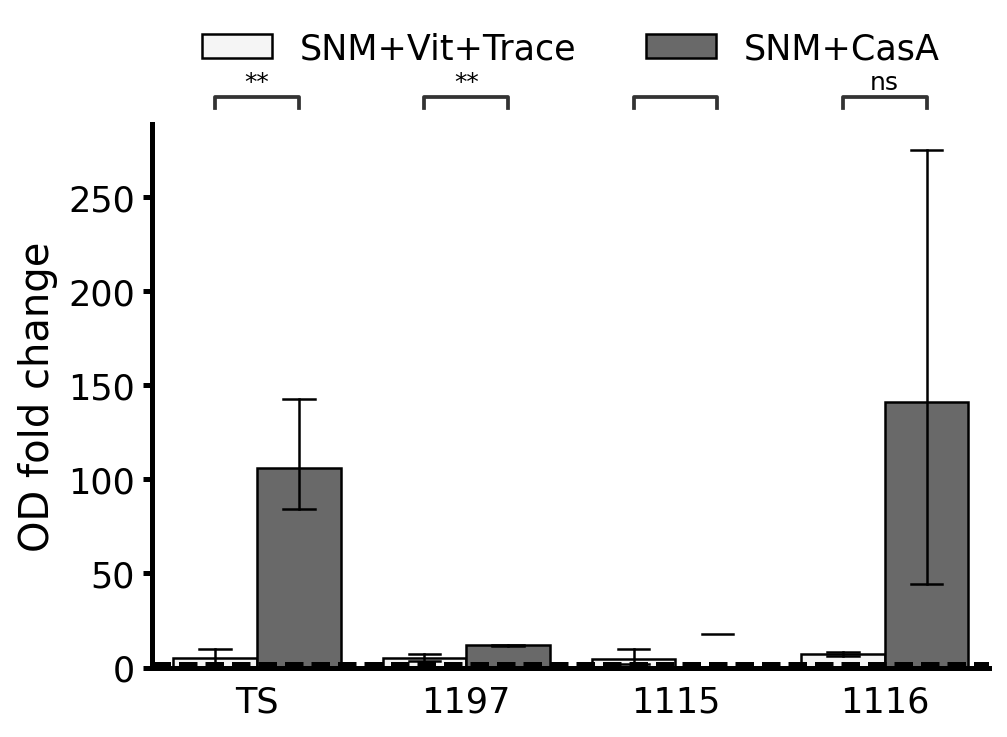

In [28]:
hue_order = ['SNM+Vit+Trace', 'SNM+CasA']
create_barplot_stats(data,x,y,hue,hue_order)

/Users/baeuerle/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/baeuerle/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/baeuerle/Library/Python/3.9/lib/python/site-packages/scipy/stats/stats.py:5452: RuntimeWarning: invalid value encountered in double_scalars
  d = mean1 - mean2


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_M9+CasA vs. 1197_SNM+CasA: t-test independent samples, P_val:2.337e-01 t=-1.401e+00
TS_M9+CasA vs. TS_SNM+CasA: t-test independent samples, P_val:4.851e-03 t=-5.644e+00
1115_M9+CasA vs. 1115_SNM+CasA: t-test independent samples, P_val:nan t=nan
1116_M9+CasA vs. 1116_SNM+CasA: t-test independent samples, P_val:1.291e-01 t=-1.907e+00


<AxesSubplot:ylabel='OD fold change'>

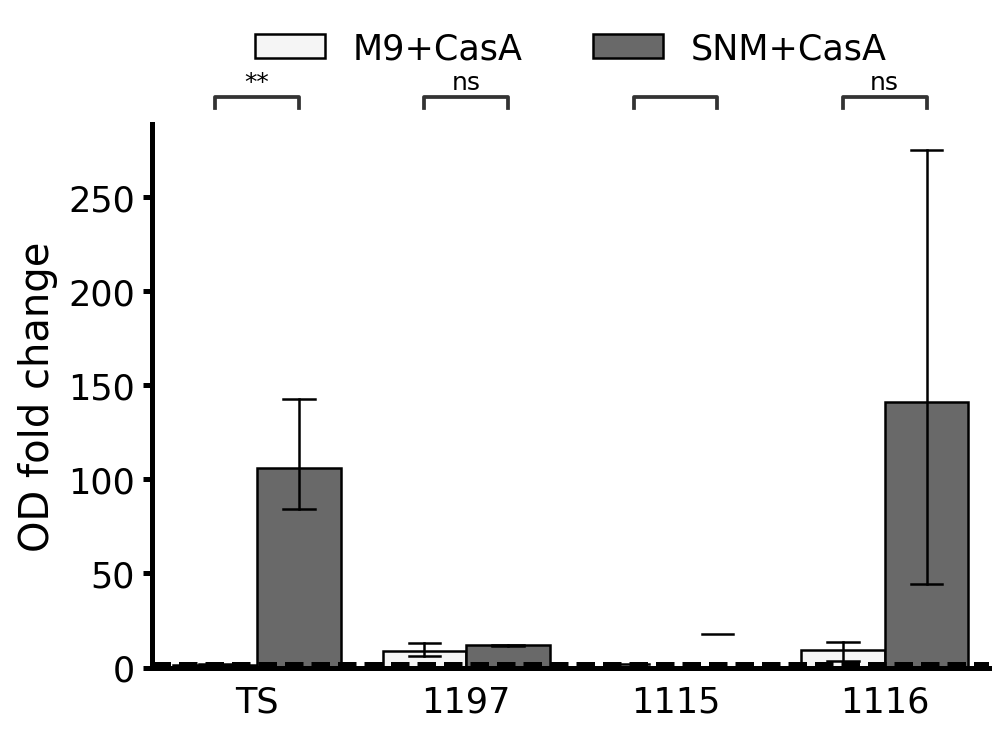

In [29]:
hue_order = ['M9+CasA', 'SNM+CasA']
create_barplot_stats(data,x,y,hue,hue_order)

### 4. Second batch of bio rep

In [30]:
#pd.options.mode.chained_assignment = None
excels = ['230127','230201', '230203', '230206']
strains = ['14', '16', '17', '15']

frames = []
i = 0
for excel in excels:
    excel_file = excel + '_Cstr.xlsx'
    strain = strains[i]
    for sample in ['-1', '-2', '-3']:
        growth = get_growth_frame(excel_file, strain)[strain+sample]
        dat = growth.loc[(growth['Time']== 15.0) | (growth['Time']== 1440.0)].abs()
        dat['sample'] = sample[1:]
        dat['strain'] = strain
        frames.append(dat)
    i = i + 1
data = pd.concat(frames, axis=0)
data

,Time,TSB,CGXII,CGXII+Tween,CGXII+CasA,CGXII+Tween+Trace,CGXII+Trace,CGXII+Tween+Sacch,CGXII+Sacc,sample,strain
0,15.0,0.057667,0.047333,0.052333,0.052000,0.054000,0.048667,0.055333,0.052000,1,14
95,1440.0,1.229333,0.086000,0.137667,0.208667,0.136333,0.087000,0.140000,0.089667,1,14
0,15.0,0.058000,0.042333,0.054000,0.051000,0.053667,0.047667,0.052667,0.046333,2,14
95,1440.0,1.118333,0.068000,0.140333,0.199333,0.125667,0.062333,0.120667,0.093667,2,14
0,15.0,0.048667,0.040667,0.046333,0.046000,0.048667,0.043333,0.046333,0.042667,3,14
95,1440.0,0.331667,0.060667,0.132000,0.199667,0.130000,0.076000,0.114000,0.082667,3,14
0,15.0,0.039000,0.027333,0.035000,0.051333,0.038333,0.073333,0.035000,0.073333,1,16
95,1440.0,0.416000,0.063333,0.055333,0.177000,0.051000,0.082000,0.043333,0.062333,1,16
0,15.0,0.051667,0.038000,0.046333,0.069667,0.043667,0.081333,0.045000,0.076667,2,16
95,1440.0,0.279667,0.098000,0.079333,0.207333,0.058333,0.078000,0.058000,0.065667,2,16


In [31]:
# group by time to determine fold
time = [v for k, v in data.groupby('Time')]
change = time[1].set_index(['sample', 'strain']).divide(time[0].set_index(['sample', 'strain']))
change.reset_index(inplace=True)
# melt to make columns into id variables
change = change.melt(id_vars=['sample', 'strain', 'Time']).rename({'variable':'medium', 'value':'OD fold change'}, axis=1)
# replace strain names
change['strain'].replace(STRAINS_LAB, inplace=True)
second = change.copy()
second

,sample,strain,Time,medium,OD fold change
0,1,TS,96.0,TSB,21.317919
1,2,TS,96.0,TSB,19.281609
2,3,TS,96.0,TSB,6.815068
3,1,1115,96.0,TSB,10.666667
4,2,1115,96.0,TSB,5.412903
...,...,...,...,...,...
91,2,1116,96.0,CGXII+Sacc,0.954248
92,3,1116,96.0,CGXII+Sacc,0.325000
93,1,1197,96.0,CGXII+Sacc,1.080645
94,2,1197,96.0,CGXII+Sacc,0.753333


In [32]:
data = second

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_CGXII vs. 1197_CGXII+Tween: t-test independent samples, P_val:3.490e-02 t=3.138e+00
TS_CGXII vs. TS_CGXII+Tween: t-test independent samples, P_val:1.032e-03 t=-8.540e+00
1115_CGXII vs. 1115_CGXII+Tween: t-test independent samples, P_val:1.904e-02 t=3.804e+00
1116_CGXII vs. 1116_CGXII+Tween: t-test independent samples, P_val:1.297e-01 t=1.903e+00


<AxesSubplot:ylabel='OD fold change'>

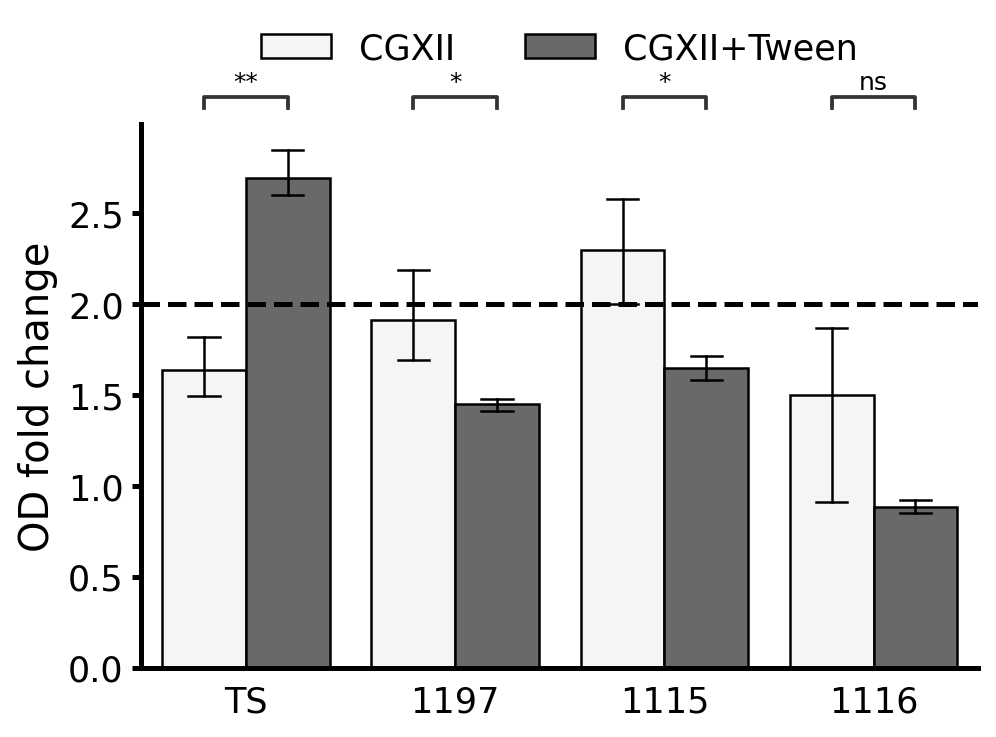

In [33]:
hue_order = ['CGXII', 'CGXII+Tween']
create_barplot_stats(data,x,y,hue,hue_order)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_CGXII vs. 1197_CGXII+CasA: t-test independent samples, P_val:1.620e-03 t=-7.586e+00
TS_CGXII vs. TS_CGXII+CasA: t-test independent samples, P_val:1.096e-04 t=-1.519e+01
1115_CGXII vs. 1115_CGXII+CasA: t-test independent samples, P_val:8.565e-01 t=-1.928e-01
1116_CGXII vs. 1116_CGXII+CasA: t-test independent samples, P_val:4.788e-02 t=-2.819e+00


<AxesSubplot:ylabel='OD fold change'>

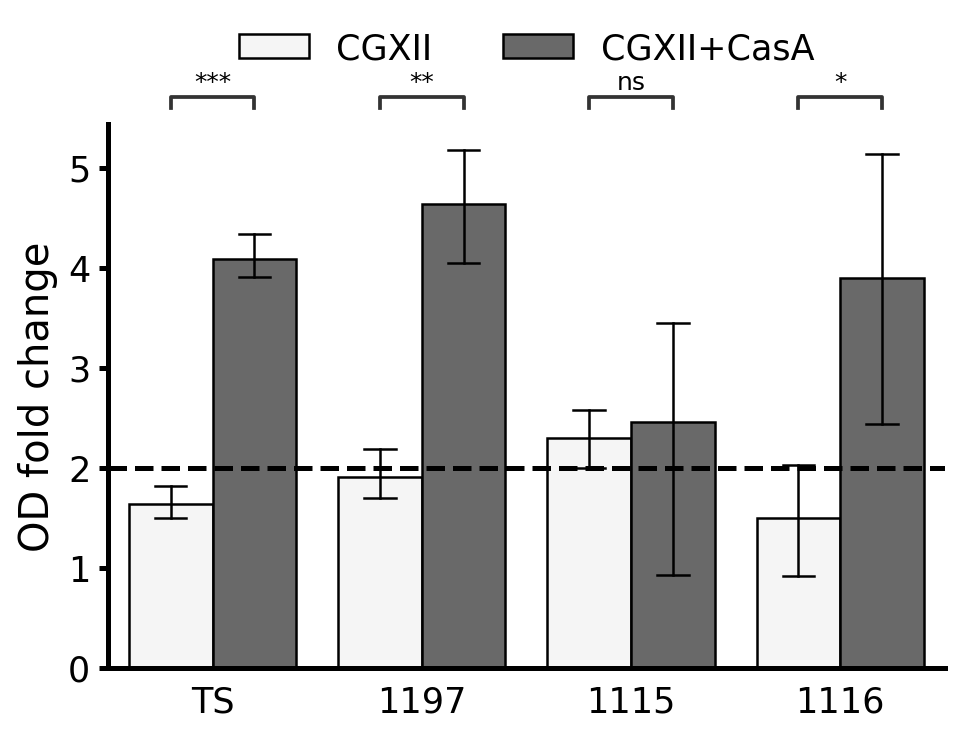

In [34]:
hue_order = ['CGXII', 'CGXII+CasA']
create_barplot_stats(data,x,y,hue,hue_order)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_CGXII vs. 1197_CGXII+Sacc: t-test independent samples, P_val:7.312e-03 t=5.034e+00
TS_CGXII vs. TS_CGXII+Sacc: t-test independent samples, P_val:1.200e-01 t=-1.971e+00
1115_CGXII vs. 1115_CGXII+Sacc: t-test independent samples, P_val:1.237e-03 t=8.145e+00
1116_CGXII vs. 1116_CGXII+Sacc: t-test independent samples, P_val:1.309e-01 t=1.896e+00


<AxesSubplot:ylabel='OD fold change'>

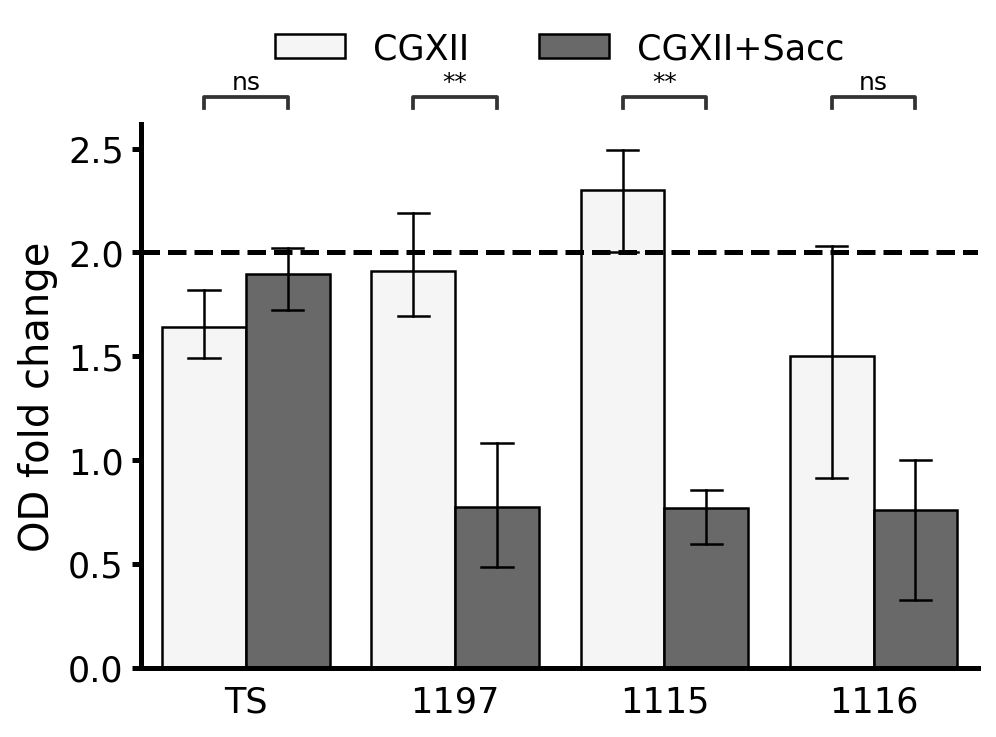

In [36]:
hue_order = ['CGXII', 'CGXII+Sacc']
create_barplot_stats(data,x,y,hue,hue_order)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_TSB vs. 1197_CGXII+CasA: t-test independent samples, P_val:2.216e-02 t=3.630e+00
TS_TSB vs. TS_CGXII+CasA: t-test independent samples, P_val:6.108e-02 t=2.584e+00
1115_TSB vs. 1115_CGXII+CasA: t-test independent samples, P_val:2.656e-02 t=3.429e+00
1116_TSB vs. 1116_CGXII+CasA: t-test independent samples, P_val:8.166e-01 t=2.477e-01


<AxesSubplot:ylabel='OD fold change'>

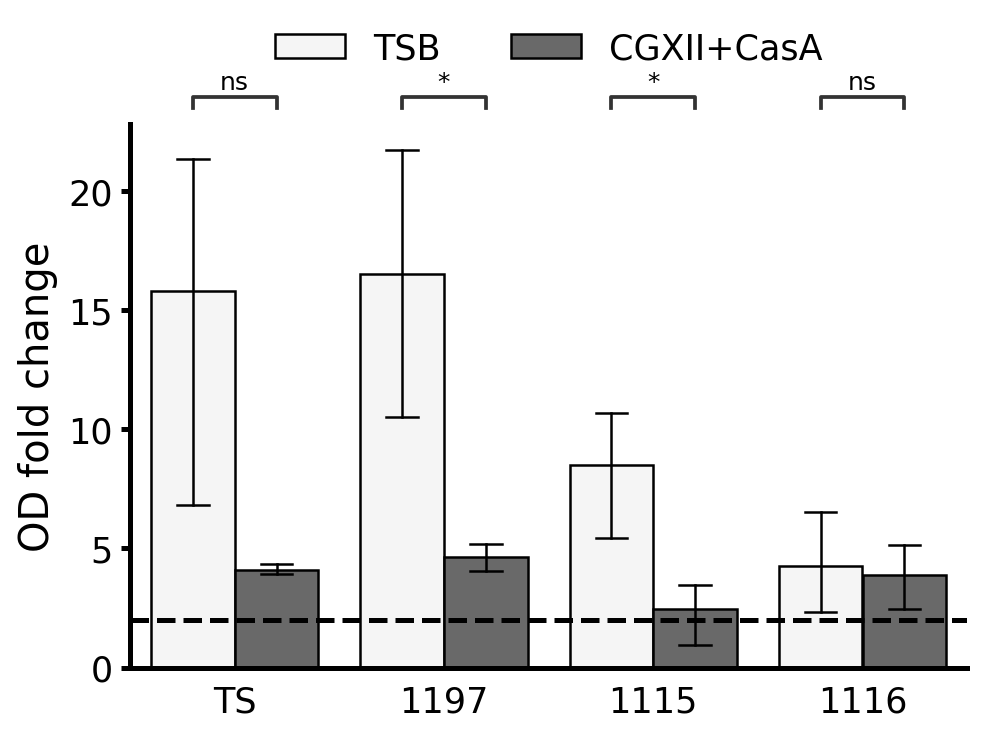

In [37]:
hue_order = ['TSB', 'CGXII+CasA']
create_barplot_stats(data,x,y,hue,hue_order)

## 4. Significance testing between t=0 and t=24

Usually a two-fold increase is considered growth. But what do we do with small folds, when does growth really occur? Significance testing between the two time points might reveal when growth occured.

In [3]:
datasets = [
    'growth_binary_results/CGXII_230111.csv', # 14
    'growth_binary_results/CGXII_230112.csv', # 16
    'growth_binary_results/CGXII_230117.csv', # 17
    #'growth_binary_results/CGXII_230124.csv', # 15
]
# read csv files
frames = [pd.read_csv(df).set_index('short').drop(['not c', '+Trace not c', '+Sacc not c']).reset_index() for df in datasets] 
# special case for strain 15 because of extra CasA measurement
frames = frames + [pd.read_csv('growth_binary_results/CGXII_230124.csv').set_index('short').drop(['not c', '+Trace not c', '+Sacc not c', '+CasA not c']).reset_index()]
# add all frames to one frame
data = pd.concat(frames, axis=1)
# remove duplicate 'short' columns
data = data.loc[:,~data.columns.duplicated()].copy()
data

,short,14-0-1,14-24-1,14-0-2,14-24-2,14-0-3,14-24-3,16-0-1,16-0-2,16-0-3,...,17-0-3,17-24-1,17-24-2,17-24-3,15-0-1,15-0-2,15-0-3,15-24-1,15-24-2,15-24-3
0,c,0.229,0.724,0.226,0.741,0.227,0.748,0.216,0.222,0.224,...,0.163,0.205,0.794,0.552,0.175,0.188,0.172,0.285,0.315,0.293
1,+Trace c,0.224,0.926,0.207,0.674,0.201,0.642,0.224,0.227,0.226,...,0.179,0.231,0.660,0.674,0.170,0.191,0.174,0.285,0.321,0.299
2,+Sacc c,0.221,0.736,0.183,0.644,0.211,0.712,0.203,0.223,0.226,...,0.180,0.279,1.222,0.691,0.164,0.172,0.168,0.269,0.288,0.298
3,+CasA c,0.234,1.723,0.226,1.738,0.199,1.628,0.205,0.229,0.233,...,0.181,0.778,5.730,7.690,0.180,0.189,0.182,0.941,0.977,0.990


In [4]:
# use stack() to bring short and measurment into rows
new = pd.DataFrame(data.set_index('short').sort_index().T.stack()).reset_index().rename({0:'OD'}, axis=1)
# split strain description
new[['strain', 'time', 'sample']] = new.level_0.str.split('-', expand=True)
# create two dataframes (at t=0 and at t=24)
new['strain'].replace(STRAINS_LAB, inplace=True)
new

,level_0,short,OD,strain,time,sample
0,14-0-1,+CasA c,0.234,TS,0,1
1,14-0-1,+Sacc c,0.221,TS,0,1
2,14-0-1,+Trace c,0.224,TS,0,1
3,14-0-1,c,0.229,TS,0,1
4,14-24-1,+CasA c,1.723,TS,24,1
...,...,...,...,...,...,...
91,15-24-2,c,0.315,1197,24,2
92,15-24-3,+CasA c,0.990,1197,24,3
93,15-24-3,+Sacc c,0.298,1197,24,3
94,15-24-3,+Trace c,0.299,1197,24,3


In [73]:
def create_barplot_stats_grid(data, x, y, hue, col, hue_order, pair1=None, pair2=None):
    strains = STRAINS_LAB.values()
    
    g = sns.FacetGrid(data, col=col, col_wrap=2)
    ### barplot with errorbars ###
    g.map(sns.barplot, data=data, x=x, y=y, 
                     hue=hue, 
                 estimator=np.mean, 
                 hue_order=hue_order,
                 palette=[greys[8], greys[0]], edgecolor='k',
                 capsize=.15, errwidth=1, errcolor='k',
                 order=STRAINS_LAB.values())
    
    ### statistics ###
    # use hue_order to infer pairs if not given
    if pair1 is None:
        pair1 = hue_order[0]
        pair2 = hue_order[1]
        
    pairs = []
    pairs = pairs + [((strain, pair1), (strain, pair2))
                for strain in strains]
    print(pairs)
    
    for ax in g.axes.flat:
        annotator = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue, #hue_order=hue_order, 
                            order=STRAINS_LAB.values())
        annotator.configure(test='t-test_ind', text_format='star'), #loc='outside')
        annotator.apply_test().annotate()
        
        ### styling ###
        #ax.legend(title=None, ncol=2)
        #sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1.05), ncol=3, title=None, frameon=False)
        ax.tick_params(bottom=False) 
        ax.set_xlabel(None)
    
    return g

In [74]:
# inputs that wont change
data = new
x = 'strain'
y = 'OD'
hue = 'time'
col = 'short'

[(('TS', '0'), ('TS', '24')), (('1197', '0'), ('1197', '24')), (('1115', '0'), ('1115', '24')), (('1116', '0'), ('1116', '24'))]
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_0 vs. 1197_24: t-test independent samples, P_val:3.719e-03 t=-3.245e+00
TS_0 vs. TS_24: t-test independent samples, P_val:6.635e-06 t=-5.868e+00
1115_0 vs. 1115_24: t-test independent samples, P_val:1.892e-02 t=-2.534e+00
1116_0 vs. 1116_24: t-test independent samples, P_val:5.275e-02 t=-2.047e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_0 vs. 1197_24: t-test independent samples, P_val:3.719e-03 t=-3.245e+00
TS_0 vs. TS_24: t-test independent samples, P_val:6.635e-06 t=-5.868e+00
1115_0 vs. 1115_24: t-test independent samples, P_val:1

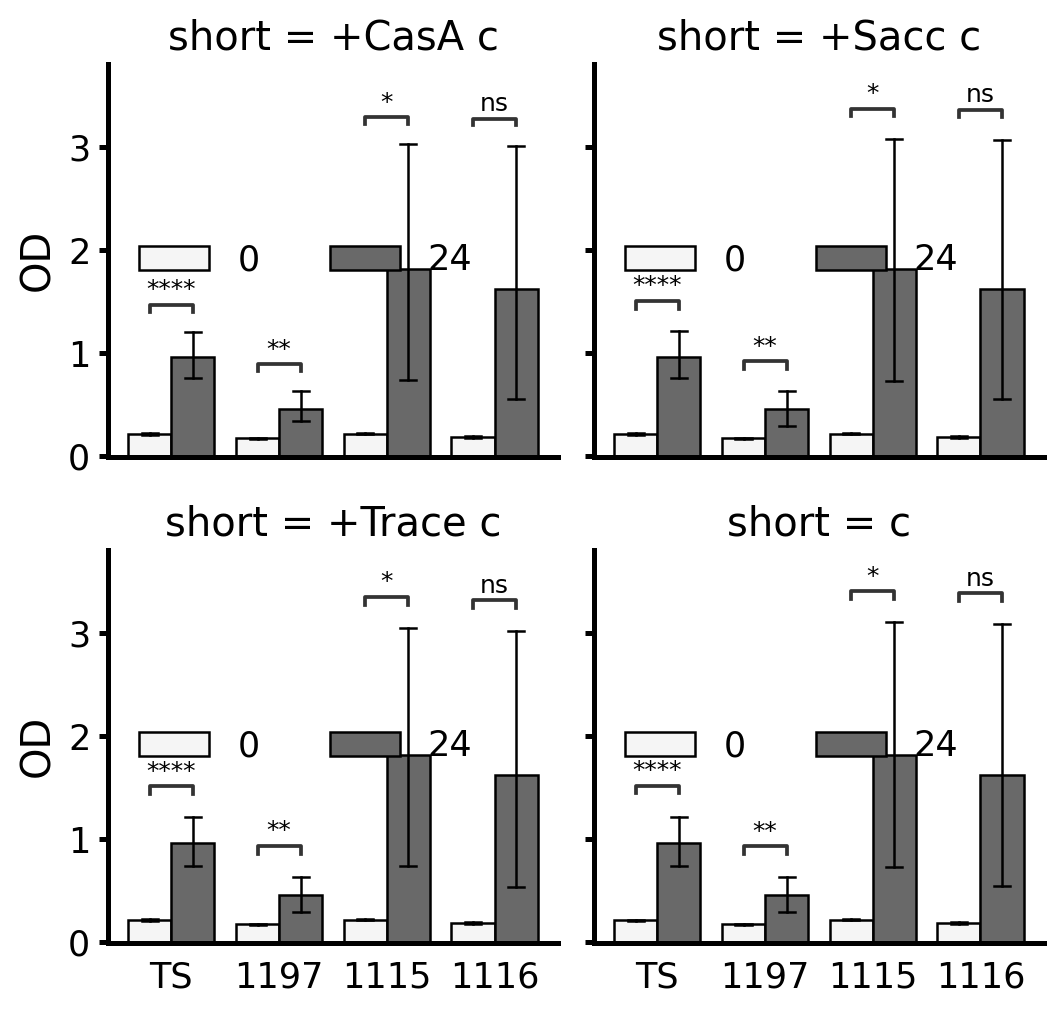

In [75]:
hue_order = ['0', '24']
fig = create_barplot_stats_grid(data,x,y,hue, col,hue_order)

## 5. Screening on M9 medium

In [4]:
datasets = [
    'growth_binary_results/M9_230203.csv', # 14
    'growth_binary_results/M9_230209.csv', # 16
]
# read csv files
frames = [pd.read_csv(df) for df in datasets] 
# add all frames to one frame
data = pd.concat(frames, axis=0)
data

,short,14-0-1,14-0-2,14-0-3,14-24-1,14-24-2,14-24-3,15-0-1,15-0-2,15-0-3,...,16-0-3,16-24-1,16-24-2,16-24-3,17-0-1,17-0-2,17-0-3,17-24-1,17-24-2,17-24-3
0,M9+Tween,0.229,0.218,0.205,0.388,0.397,0.408,0.225,0.227,0.211,...,0.256,0.405,0.443,0.417,0.256,0.214,0.224,0.594,0.297,0.772
1,M9+Tween+CasA,0.235,0.233,0.206,2.630,1.740,1.720,0.210,0.329,0.213,...,0.286,1.760,2.190,2.120,0.228,0.214,0.219,1.590,1.270,2.360
0,M9,0.184,0.186,0.179,0.226,0.289,0.344,0.226,0.210,0.211,...,0.212,0.262,0.293,0.298,0.238,0.196,0.234,0.592,0.486,0.587
1,M9+Tween+nac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.189,0.206,0.190,2.230,2.570,2.570
2,M9+Tween+nac+CasA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.184,0.197,0.193,2.160,2.610,2.220


In [5]:
# use stack() to bring short and measurment into rows
new = pd.DataFrame(data.set_index('short').sort_index().T.stack()).reset_index().rename({0:'OD'}, axis=1)
# split strain description
new[['strain', 'time', 'sample']] = new.level_0.str.split('-', expand=True)
# create two dataframes (at t=0 and at t=24)
time = [v for k, v in new.groupby('time')]
change = time[1]
# determine fold change by dividing t=24 by t=0
change['OD fold change'] = time[1]['OD'].values / time[0]['OD'].values
# change strain from lab names to real names
change['strain'].replace(STRAINS_LAB, inplace=True)
change

,level_0,short,OD,strain,time,sample,OD fold change
9,14-24-1,M9,0.226,TS,24,1,1.228261
10,14-24-1,M9+Tween,0.388,TS,24,1,1.694323
11,14-24-1,M9+Tween+CasA,2.630,TS,24,1,11.191489
12,14-24-2,M9,0.289,TS,24,2,1.553763
13,14-24-2,M9+Tween,0.397,TS,24,2,1.821101
14,14-24-2,M9+Tween+CasA,1.740,TS,24,2,7.467811
15,14-24-3,M9,0.344,TS,24,3,1.921788
16,14-24-3,M9+Tween,0.408,TS,24,3,1.990244
17,14-24-3,M9+Tween+CasA,1.720,TS,24,3,8.349515
27,15-24-1,M9,1.079,1197,24,1,4.774336


In [7]:
# inputs that wont change
data = change
x = 'strain'
y = 'OD fold change'
hue = 'short'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_M9 vs. 1197_M9+Tween+nac: t-test independent samples, P_val:nan t=nan
TS_M9 vs. TS_M9+Tween+nac: t-test independent samples, P_val:nan t=nan
1115_M9 vs. 1115_M9+Tween+nac: t-test independent samples, P_val:nan t=nan
1116_M9 vs. 1116_M9+Tween+nac: t-test independent samples, P_val:3.607e-05 t=-2.011e+01


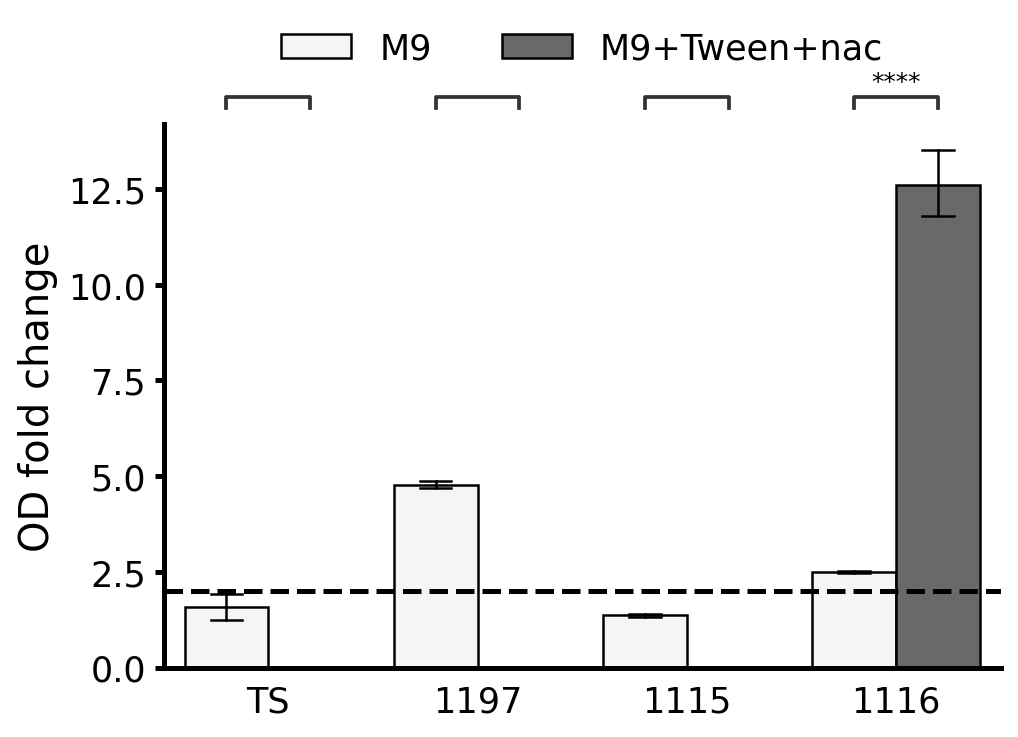

In [10]:
# input
hue_order = ['M9', 'M9+Tween+nac']
fig = create_barplot_stats(data,x,y,hue,hue_order)

In [11]:
plt.close('all')

## 6. Batch screening on CGXII, complete

In [78]:
datasets = [
    'growth_binary_results/CGXII_230111.csv', # 14
    'growth_binary_results/CGXII_230112.csv', # 16
]
frames = [pd.read_csv(df).set_index('short').drop(['not c', '+Trace not c', '+Sacc not c', '+Tween+Sacc c']).reset_index() for df in datasets] 
frames = frames + [pd.read_csv('growth_binary_results/CGXII_230124.csv').set_index('short').drop(['not c', '+Trace not c', '+Sacc not c', '+CasA not c', '+Tween+Sacc c']).reset_index()] #15
#strain 17, remove CasA results from 1701 and use from 2301
frames = frames + [pd.read_csv('growth_binary_results/CGXII_combine_strain17.csv')]
frames_new = [frame.replace({
    '+Tween c':'CGXII+Tween',
    '+Tween+Trace c':'CGXII+Tween+Trace',
    '+Tween+CasA c': 'CGXII+Tween+CasA'
}) for frame in frames]  
datasets2 = [
    'growth_binary_results/CGXII_230209.csv',
    'growth_binary_results/CGXII_230210.csv'
]
frames2 = [pd.read_csv(df) for df in datasets2]
data = pd.concat(frames_new, axis=1)
data = data.loc[:,~data.columns.duplicated()].copy()
data = data.append(frames2)
data

,short,14-0-1,14-24-1,14-0-2,14-24-2,14-0-3,14-24-3,16-0-1,16-0-2,16-0-3,...,15-0-3,15-24-1,15-24-2,15-24-3,17-0-1,17-0-2,17-0-3,17-24-1,17-24-2,17-24-3
0,CGXII+Tween,0.229,0.724,0.226,0.741,0.227,0.748,0.216,0.222,0.224,...,0.172,0.285,0.315,0.293,0.186,0.181,0.199,0.210,0.209,0.227
1,CGXII+Tween+Trace,0.224,0.926,0.207,0.674,0.201,0.642,0.224,0.227,0.226,...,0.174,0.285,0.321,0.299,0.187,0.196,0.201,0.752,0.800,0.822
2,CGXII+Tween+CasA,0.234,1.723,0.226,1.738,0.199,1.628,0.205,0.229,0.233,...,0.182,0.941,0.977,0.990,0.224,0.926,0.207,0.674,0.201,0.642
0,CGXII,0.182,0.310,0.183,0.279,0.173,0.278,0.215,0.206,0.173,...,0.181,0.196,0.284,0.292,0.180,0.178,0.169,0.169,0.206,0.167
1,CGXII+nac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.159,0.159,0.165,0.217,0.122,0.153
2,CGXII+Tween+nac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.182,0.188,0.193,0.324,0.330,0.335
3,CGXII+Tween+nac+CasA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.188,0.188,0.197,1.151,1.125,1.169
0,CGXII+CasA,0.200,1.200,0.194,1.270,0.206,1.270,0.228,0.206,0.221,...,0.197,1.070,1.140,1.110,0.201,0.201,0.177,0.740,0.570,0.710
1,CGXII+Tween+Vit,0.263,0.942,0.203,0.712,0.206,0.677,0.217,0.211,0.214,...,0.208,0.470,0.510,0.505,0.217,0.228,0.204,0.283,0.291,0.265
2,CGXII+Tween+Vit+Trace,0.209,0.645,0.201,0.619,0.220,0.641,0.247,0.207,0.209,...,0.209,0.443,0.493,0.480,0.223,0.212,0.152,0.296,0.276,0.216


In [79]:
# use stack() to bring short and measurment into rows
new = pd.DataFrame(data.set_index('short').sort_index().T.stack()).reset_index().rename({0:'OD'}, axis=1)
# split strain description
new[['strain', 'time', 'sample']] = new.level_0.str.split('-', expand=True)
# create two dataframes (at t=0 and at t=24)
time = [v for k, v in new.groupby('time')]
change = time[1]
# determine fold change by dividing t=24 by t=0
change['OD fold change'] = time[1]['OD'].values / time[0]['OD'].values
# change strain from lab names to real names
change['strain'].replace(STRAINS_LAB, inplace=True)
change

,level_0,short,OD,strain,time,sample,OD fold change
10,14-24-1,CGXII+Tween+CasA,1.723,TS,24,1,7.363248
24,14-24-2,CGXII+Tween+CasA,1.738,TS,24,2,7.690265
38,14-24-3,CGXII+Tween+CasA,1.628,TS,24,3,8.180905
66,16-24-1,CGXII+Tween+CasA,6.820,1115,24,1,33.268293
73,16-24-2,CGXII+Tween+CasA,4.100,1115,24,2,17.903930
80,16-24-3,CGXII+Tween+CasA,4.910,1115,24,3,21.072961
108,15-24-1,CGXII+Tween+CasA,0.941,1197,24,1,5.227778
115,15-24-2,CGXII+Tween+CasA,0.977,1197,24,2,5.169312
122,15-24-3,CGXII+Tween+CasA,0.990,1197,24,3,5.439560
165,17-24-1,CGXII+Tween+CasA,0.674,1116,24,1,3.008929


In [80]:
# inputs that wont change
data = change
x = 'strain'
y = 'OD fold change'
hue = 'short'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1197_CGXII vs. 1197_CGXII+Tween+nac+CasA: t-test independent samples, P_val:nan t=nan
TS_CGXII vs. TS_CGXII+Tween+nac+CasA: t-test independent samples, P_val:nan t=nan
1115_CGXII vs. 1115_CGXII+Tween+nac+CasA: t-test independent samples, P_val:nan t=nan
1116_CGXII vs. 1116_CGXII+Tween+nac+CasA: t-test independent samples, P_val:5.521e-07 t=-5.739e+01


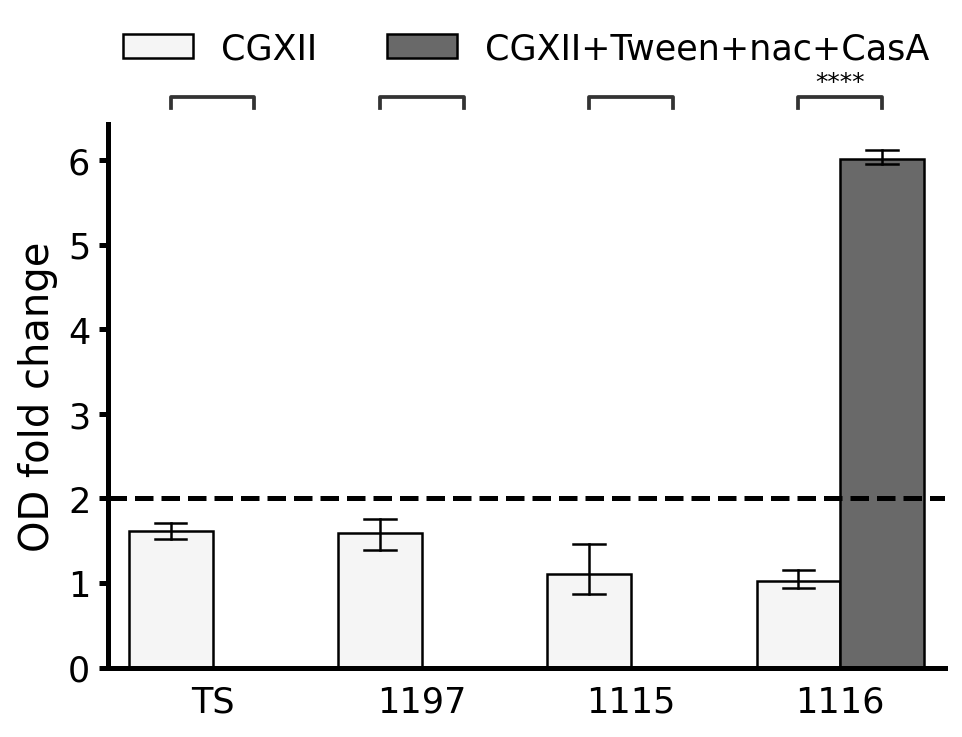

In [83]:
hue_order = ['CGXII', 'CGXII+Tween+nac+CasA']
fig = create_barplot_stats(data,x,y,hue,hue_order)